In [1]:
import sys
sys.path.append('../centroFlye_repo/scripts')

import os
import numpy as np
from itertools import groupby
import edlib
import mappy as mp

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from utils.bio import read_bio_seq, read_bio_seqs
from ncrf_parser import NCRF_Report

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]


# Appendix: Reads with DXZ1 in both orientations

In [3]:
centroFlye_results_dir = "../data/centroFlye_results"

reads_ncrf_fn = \
os.path.join(centroFlye_results_dir, 'NCRF_rc', 'report.ncrf')


In [4]:
reads_ncrf = NCRF_Report(reads_ncrf_fn)

In [5]:
def get_reads_both_orientation(reads_ncrf, min_alignment_length=2055):
    r_ids = []
    for r_id, pos in reads_ncrf.positions_all_alignments.items():
        pos = [p for p in pos if p[1] - p[0] > min_alignment_length]
        strands = set([p[2] for p in pos])
        if '+' in strands and '-' in strands:
            r_ids.append(r_id)
    return r_ids

In [6]:
both_orientation_reads = get_reads_both_orientation(reads_ncrf)
for r_id in both_orientation_reads:
    print(r_id[:8], reads_ncrf.positions_all_alignments[r_id])

90d75f6b [(104, 92329, '-'), (171875, 196754, '+')]
548b4279 [(88, 69757, '+'), (70023, 75522, '-')]
a22bcdef [(125, 13596, '-'), (13605, 52547, '+')]
61a30b9f [(90, 8682, '-'), (8878, 15309, '+'), (16094, 17026, '+')]


# Appendix. Analysis of Alu insertions

In [7]:
reads_fn = \
os.path.join(centroFlye_results_dir, 'centromeric_reads', 'centromeric_reads.fasta')

# If you wish to replicate the following analysis,
# please obtain a version of RepBase library
# and change the path accordingly
alu_fn = \
"/Poppy/data/repbase/20190225/RepBase24.02.fasta/humsub.ref"


In [8]:
def align(targets, queries, threshold=0.3, verbose=True):
    aligned_pairs = []
    for i, (t_id, t_seq) in enumerate(targets.items()):
        if i % 100 == 0:
            print(i + 1, len(targets))
        for q_id, q_seq in queries.items():
            q_seq_rc = mp.revcomp(q_seq)
            score = edlib.align(q_seq, t_seq, mode='HW')["editDistance"]
            score_rc = edlib.align(q_seq_rc, t_seq, mode='HW')["editDistance"]
            score = min(score, score_rc)
            if score < len(q_seq) * threshold:
                aligned_pairs.append((t_id, q_id))
                if verbose:
                    print(t_id[:8], q_id)
    return aligned_pairs

In [9]:
reads = read_bio_seqs(reads_fn)

In [10]:
reads_aligned = {}
for r_id, pos in reads_ncrf.positions_all_alignments.items():
    left_border = min(p[0] for p in pos)
    right_border = max(p[1] for p in pos)
    reads_aligned[r_id] = reads[r_id][left_border:right_border]

Alignments in selected regions

In [11]:
alu = {}
for alu_id, alu_seq, _ in mp.fastx_read(alu_fn):
    alu[alu_id] = alu_seq.upper()

aligned_pairs = align(reads_aligned, alu)

1 2680
101 2680
201 2680
301 2680
401 2680
501 2680
601 2680
701 2680
801 2680
901 2680
1001 2680
1101 2680
1201 2680
1301 2680
1401 2680
1501 2680
1601 2680
1701 2680
1801 2680
1901 2680
2001 2680
2101 2680
2201 2680
2301 2680
2401 2680
2501 2680
2601 2680


In [12]:
aligned_pairs

[]

Alignments of full reads

In [13]:
aligned_pairs = align(reads, alu, verbose=False)

1 2680
101 2680
201 2680
301 2680
401 2680
501 2680
601 2680
701 2680
801 2680
901 2680
1001 2680
1101 2680
1201 2680
1301 2680
1401 2680
1501 2680
1601 2680
1701 2680
1801 2680
1901 2680
2001 2680
2101 2680
2201 2680
2301 2680
2401 2680
2501 2680
2601 2680


In [14]:
alu_reads = set([pair[0] for pair in aligned_pairs])

In [15]:
len(alu_reads)

27

In [16]:
prefix_reads, internal_reads, suffix_reads = reads_ncrf.classify()

In [17]:
cnt_prefix_reads, cnt_suffix_reads = 0, 0
for r_id in alu_reads:
    cnt_prefix_reads += r_id in prefix_reads
    cnt_suffix_reads += r_id in suffix_reads
print(cnt_prefix_reads), print(cnt_suffix_reads)

1
5


(None, None)

In [18]:
centroFlye_mapped_pos_fn = \
os.path.join(centroFlye_results_dir, "tr_resolution", "read_positions.csv")
mapped_pos = {}
with open(centroFlye_mapped_pos_fn) as f:
    for line in f:
        line = line.strip().split(' ')
        if len(line) == 1:
            mapped_pos[line[0]] = 0
        elif line[1] == "None":
            mapped_pos[line[0]] = None
        else:
            mapped_pos[line[0]] = int(line[1])

In [19]:
cnt_unmapped = 0
cnt_prefix_reads, cnt_suffix_reads = 0, 0
for r_id in alu_reads:
    if r_id in mapped_pos:
        cnt_prefix_reads += r_id in prefix_reads
        cnt_suffix_reads += r_id in suffix_reads 
        #print(r_id[:8], mapped_pos[r_id], r_id in prefix_reads, r_id in suffix_reads)
    else:
        #print(r_id[:8], None)
        cnt_unmapped += 1
print(cnt_prefix_reads), print(cnt_suffix_reads), print(cnt_unmapped)
pass

1
5
14


# Appendix: Analyzing non-uniform read coverage of the T2T read-set

The following coverage file was created with commands:

1. ```awk '{ if ($2 > 50000) { print($1)} }' data/rel2/rel2.fastq.fai > rel2_50k.txt```
2. ```java -jar ~/soft/picard/build/libs/picard.jar FilterSamReads I=rel2_to_GRCh38.bam O=rel2_to_GRCh38_50k.bam READ_LIST_FILE=rel2_50k.txt FILTER=includeReadList VALIDATION_STRINGENCY=LENIENT```
3. ```samtools index rel2_to_GRCh38_50k.bam```
4. ```genomeCoverageBed -d -ibam rel2_to_GRCh38_50k.bam > rel2_to_GRCh38_50k_coverage.txt```
5. ```grep "chrX" rel2_to_GRCh38_50k_coverage.txt > rel2_to_GRCh38_50k_chrX_coverage.txt```
6. ```grep -v "chrX_" rel2_to_GRCh38_50k_chrX_coverage.txt > rel2_to_GRCh38_50k_chrX_coverage_main.txt```
7. ```mv rel2_to_GRCh38_50k_chrX_coverage_main.txt rel2_to_GRCh38_50k_chrX_coverage.txt```

In [20]:
coverage_X_fn = \
"../data/rel2/rel2_to_GRCh38_50k_chrX_coverage.txt"

In [21]:
def read_coverage(coverage_fn):
    coverage = []
    with open(coverage_fn) as f:
        for line in f:
            chrom, pos, cov = line.strip().split('\t')
            pos, cov = int(pos), int(cov)
            assert pos == len(coverage) + 1
            coverage.append(cov)
    return np.array(coverage)

In [22]:
coverage_X = read_coverage(coverage_X_fn)

In [23]:
len(coverage_X)

156040895

In [24]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [25]:
def plot_coverage_region(coverage, left_border, region_len, title, moving_average_window=10000, xlabel='chrX'):
    left_border_mm, region_len_mm = int(left_border*10**6), int((region_len)*10**6)
    coverage_region = coverage[left_border_mm:left_border_mm+region_len_mm]
    coverage_region = moving_average(coverage_region, n=moving_average_window)
    plt.ticklabel_format(style='plain')
    plt.plot(range(left_border_mm, left_border_mm + len(coverage_region)), coverage_region)
    plt.ylim((0, 50))
    plt.xticks(fontsize=16, rotation=30)
    plt.yticks(fontsize=16)
    plt.xlabel(f'Position in {xlabel}', fontsize=18)
    plt.ylabel('Coverage', fontsize=18)
    plt.title(title, fontsize=20)
    

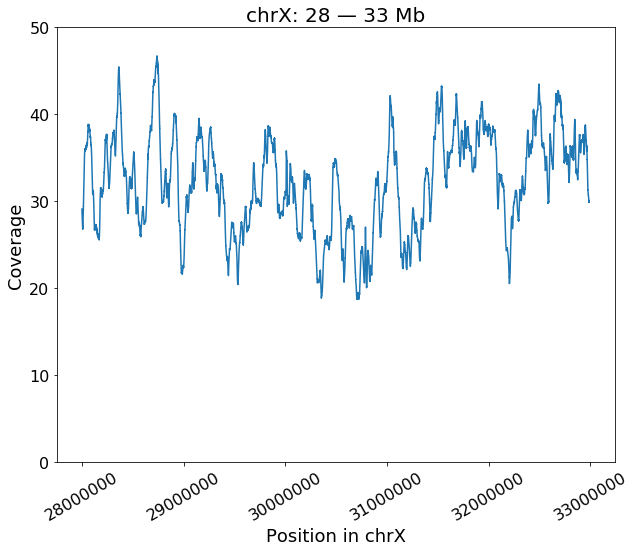

In [26]:
plot_coverage_region(coverage_X, left_border=28, region_len=5, title='chrX: 28 — 33 Mb')


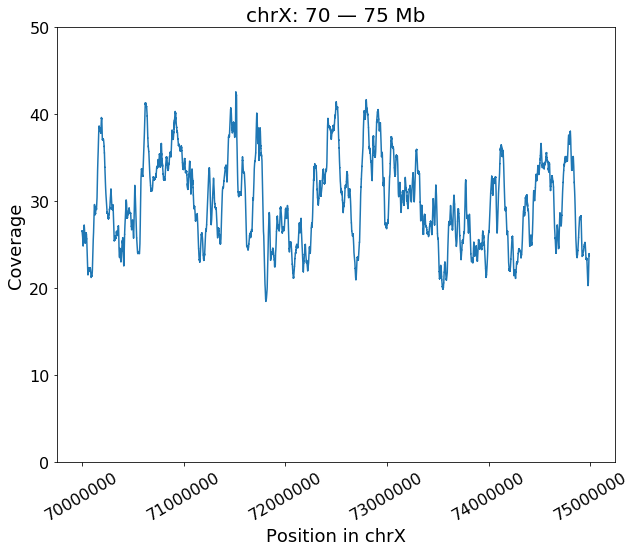

In [27]:
plot_coverage_region(coverage_X, left_border=70, region_len=5, title='chrX: 70 — 75 Mb')

In [28]:
median_cov_X = np.median(coverage_X)
print(median_cov_X)

30.0


In [29]:
np.sum(coverage_X > 1.5 * median_cov_X) + np.sum(coverage_X < 0.5 * median_cov_X)

7628215

In [30]:
np.percentile(coverage_X, [5, 50, 95])

array([ 19.,  30.,  43.])

In [31]:
def get_peaks_width(coverage, moving_average_window=10000):
    # from https://stackoverflow.com/a/1066838
    def runs_of_ones(bits):
        for bit, group in groupby(bits):
            if bit: yield sum(group)
    
    p5, p95 = np.percentile(coverage, [5, 95])
    print(p5, p95)
    coverage = moving_average(coverage, n=moving_average_window)
    peaks = ((coverage < p5) + (coverage > p95))
    print(peaks)
    peaks_width = np.array(list(runs_of_ones(peaks)))
    return peaks_width

In [32]:
peaks_width = get_peaks_width(coverage_X)

19.0 43.0
[ True  True  True ...,  True  True  True]


In [33]:
np.mean(peaks_width), np.median(peaks_width), np.max(peaks_width)

(23893.162361623617, 10237.0, 341483)